<a href="https://colab.research.google.com/github/imjoung/DataScience/blob/main/ml/10_DecisionTreeClassifier_%EC%9C%A0%EB%B0%A9%EC%95%94_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

문제정의 : Decision tree classifier 를 사용하여 유방암 예측하기

In [28]:
# 기본 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split

# 한글 깨짐 방지
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


### step 1) 데이터 준비 - UCL ML Repository 제공하는 Breast Cancer 데이터셋 가져오기
- # Breast Cancer 데이터셋 가져오기 (출처: UCI ML Repository)

In [29]:
uci_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/\
breast-cancer-wisconsin/breast-cancer-wisconsin.data'

df = pd.read_csv(uci_path,header=None)

In [30]:
# 열 이름 지정
df.columns = ['id', 'clump', 'cell_size', 'cell_shape', 'adhesion', 'epithlial',
              'bare_nuclei', 'chromatin', 'normal_nucleoli', 'mitoses', 'class']

### step 2) 데이터 탐색 및 데이터 전처리

In [31]:
df.head()

,id,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [32]:
# 데이터 자료형 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               699 non-null    int64 
 1   clump            699 non-null    int64 
 2   cell_size        699 non-null    int64 
 3   cell_shape       699 non-null    int64 
 4   adhesion         699 non-null    int64 
 5   epithlial        699 non-null    int64 
 6   bare_nuclei      699 non-null    object
 7   chromatin        699 non-null    int64 
 8   normal_nucleoli  699 non-null    int64 
 9   mitoses          699 non-null    int64 
 10  class            699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [33]:
# bare_nuclei 열의 자료형 변경(문자형 -> 숫자형)
# bare_nuclei 열의 고유 값 확인
print(df['bare_nuclei'].unique())

['1' '10' '2' '4' '3' '9' '7' '?' '5' '8' '6']


In [34]:
# '?'을 np.nan으로 변경
df['bare_nuclei'].replace('?',np.nan,inplace=True)

In [35]:
# np.nan으로 변경된 값을 삭제
df.dropna(subset=['bare_nuclei'],axis=0,inplace=True)

In [36]:
# 문자열을 숫자형으로 변경
df['bare_nuclei'] = df['bare_nuclei'].astype('int')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   id               683 non-null    int64
 1   clump            683 non-null    int64
 2   cell_size        683 non-null    int64
 3   cell_shape       683 non-null    int64
 4   adhesion         683 non-null    int64
 5   epithlial        683 non-null    int64
 6   bare_nuclei      683 non-null    int64
 7   chromatin        683 non-null    int64
 8   normal_nucleoli  683 non-null    int64
 9   mitoses          683 non-null    int64
 10  class            683 non-null    int64
dtypes: int64(11)
memory usage: 64.0 KB


### step 3) 분석에 사용할 속성 선택

In [38]:
# 속성(변수) 선택
X = df[['clump','cell_size','cell_shape','adhesion','epithlial',
        'bare_nuclei','chromatin','normal_nucleoli','mitoses']] # 설명변수 X
y = df['class'] # 예측변수 y

In [39]:
# 설명 변수 데이터를 정규화
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

### step 4) 데이터셋 구분 - 훈련용/검증용

In [40]:
# train 데이터와 test데이터 구분 (7:3 비율)
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=7)
print("train 데이터 개수: ",X_train.shape) 
print("test 데이터 개수: ",X_test.shape) 

train 데이터 개수:  (478, 9)
test 데이터 개수:  (205, 9)


### step 5) Decision tree 분류 모형 - sklearn 사용

In [57]:
# sklearn 라이브러리에서 Decision Tree 분류모형 가져오기
# 모형 객체 생성(최적의 속성을 찾기 위해 criterion='entropy'적용) *적정한 레벨 값 찾는 것
tree_model = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)

In [58]:
# 훈련 데이터를 사용하여 모형 학습
tree_model.fit(X_train,y_train)

# 테스트 데이터를 사용하여 y_hat 예측
y_hat = tree_model.predict(X_test)

### step 6) 모델 성능 평가

In [59]:
print(f"train set 정확도 : {tree_model.score(X_train, y_train)*100:.2f}")
print(f"test set 정확도 : {tree_model.score(X_test, y_test)*100:.2f}")

train set 정확도 : 97.28
test set 정확도 : 95.12


In [60]:
# 모형 성능 평가 - 평가지표 계산
tree_report = metrics.classification_report(y_test,y_hat)
print(tree_report)

              precision    recall  f1-score   support

           2       0.98      0.95      0.96       131
           4       0.91      0.96      0.93        74

    accuracy                           0.95       205
   macro avg       0.94      0.95      0.95       205
weighted avg       0.95      0.95      0.95       205



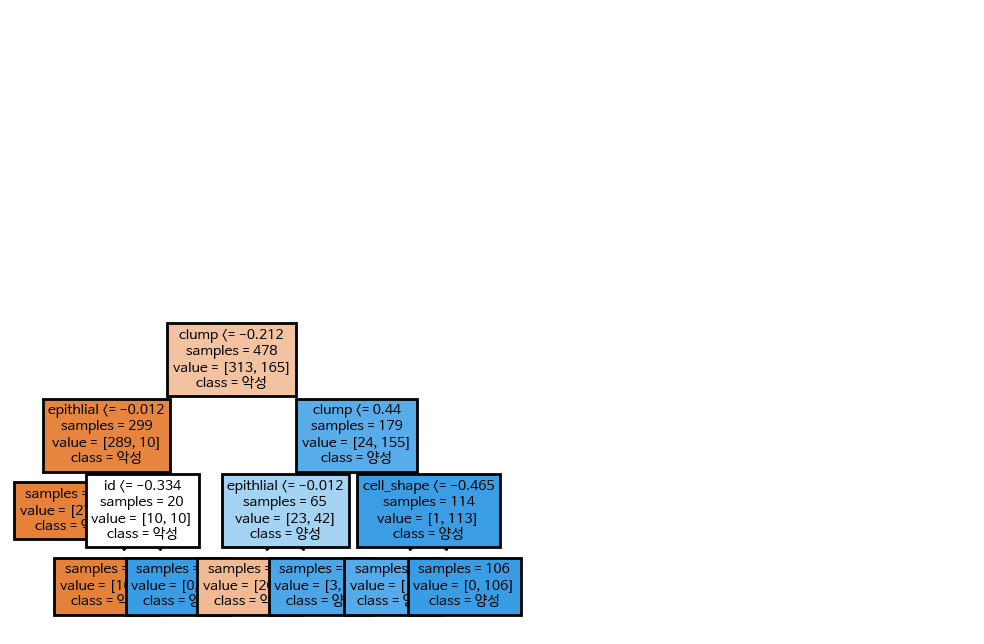

In [61]:
from sklearn.tree import plot_tree
plt.figure(dpi=100)
plot_tree(tree_model, class_names=['악성', '양성'],
          feature_names=df.columns, impurity=False, filled = True)
plt.show()

In [62]:
from sklearn.tree import export_graphviz
export_graphviz(tree_model, out_file="tree.dot", class_names=["악성","양성"],
                feature_names=df.columns[1:10], impurity=False, filled=True)

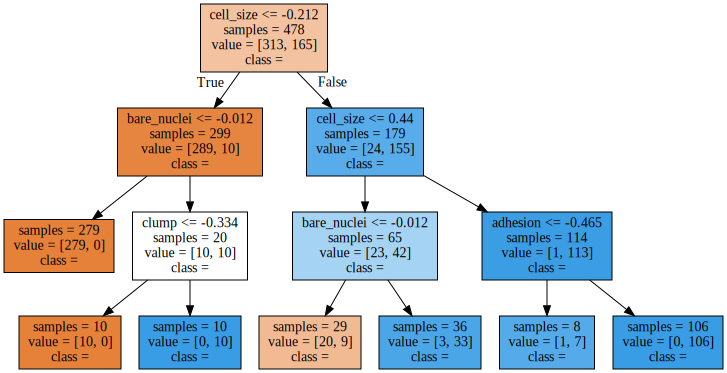

In [63]:
import graphviz
with open("tree.dot") as f:
  dot_graph = f.read()
display(graphviz.Source(dot_graph))

최적의 max_depth 설정하기

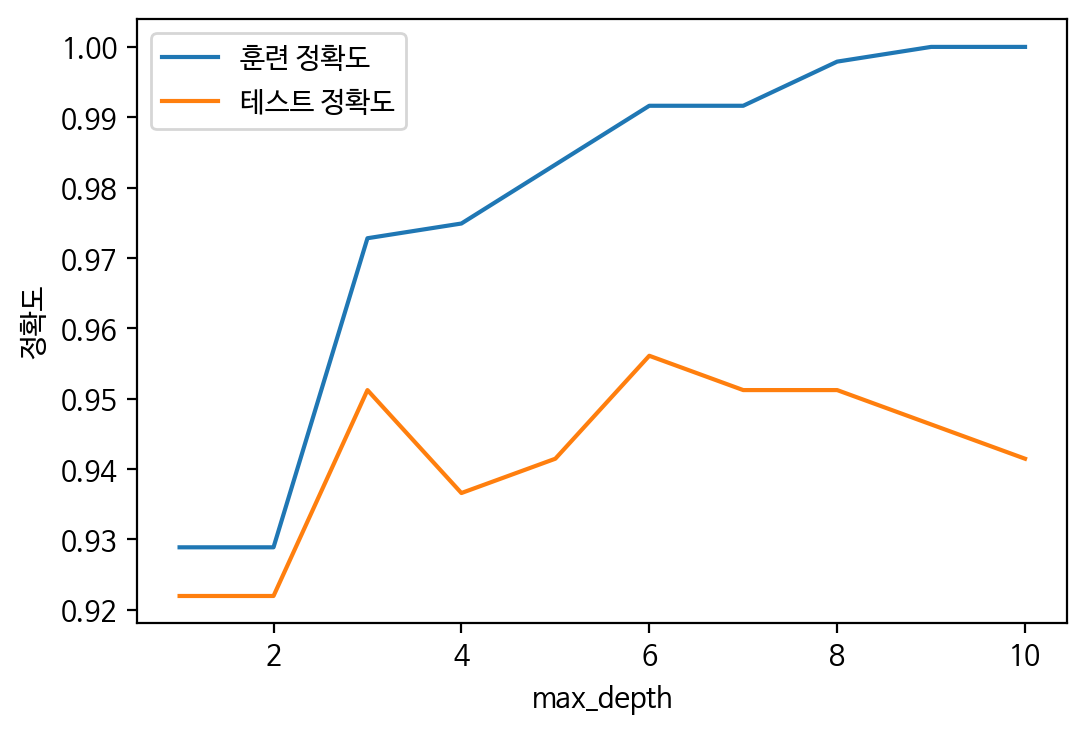

In [64]:
training_accuracy = []
test_accuracy = []
# 1 에서 10 까지 max_depth 를 적용
max_depth_settings = range(1, 11)

for max_depth in max_depth_settings:
    # 모델 생성
    tr = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    tr.fit(X_train, y_train)
    # 훈련 세트 정확도 저장
    training_accuracy.append(tr.score(X_train, y_train))
    # 테스트 세트(일반화) 정확도 저장
    test_accuracy.append(tr.score(X_test, y_test))

plt.figure(dpi = 100)
plt.rc('font', family ='NanumBarunGothic')

plt.plot(max_depth_settings, training_accuracy, label="훈련 정확도")
plt.plot(max_depth_settings, test_accuracy, label="테스트 정확도")
plt.ylabel("정확도")
plt.xlabel("max_depth")
plt.legend()
plt.show()
